<a href="https://colab.research.google.com/github/brianosmith/PREfitting/blob/main/Fitting_PRE_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting paramagnetic relaxation enhancement data

## Theory
The effect of PREs on HSQC crosspeak intensitities can be described by 

$
I_{para}/I_{dia}=R_2e^{−R_2^{sp}t}/(R_2+R_2^{sp})
$

where, $I_{para}$ and $I_{dia}$ are the measured intensities of the cross peaks for the paramagnetic and diamagnetic forms of the protein, respectively, and t is the total evolution time of the transverse proton magnetization during the NMR experiment. The values of R correspond to the rate of the transverse relaxation of the amide proton, $R_2$ is the intrinsic relaxation rate of the proton, $R_2^{sp}$, is the contribution to the relaxation caused by the paramagnetic probe.

The value of $R_2^{sp}$ is dependent upon r, the distance between the amide proton and the probe. This relationship is described by a modified version of the Solomon-Bloembergen (Solomon and Bloembergen, 1956; Battiste and Wagner, 2000)

$
r=[(K/R_2^{sp})(4τ_c+{3τ_c}/{(1+ω_H^2τ_c^2)})]^{1/6}
$

where, K is a constant ($1.23 × 10^{-32} cm^6 sec^{-2}$) that describes the spin properties of the MTSL spin label (Battiste and Wagner, 2000), $ω_H$ is the Larmor frequency of the proton spin, $τ_c$ is the apparent PRE correlation time (Simon et al., 2010). $ω_H$ is known and values of $τ_c$ can be estimated based on either the molecular weight of the protein (Cavanagh et al., 1995) or based on $^{15}$N backbone relaxation measurements.

Rearranging the first equation

$
R_2^{sp} = -R_2 + \frac{1}{t}\times W(\frac{R_2te^{R_2t}}{I_{para}/I_{dia}})
$

where W() is the Lambert function.

In [49]:
from sympy import *
init_printing(use_unicode=True)

ratio, t, R2, R2sp = symbols('I_r, t R_2 R_2^{sp}')

Eq(ratio,(R2*exp(-1*R2sp*t))/(R2+R2sp))

solve(Eq(ratio,(R2*exp(-1*R2sp*t))/(R2+R2sp)),R2sp)
#W() in this solution is the Lambert function

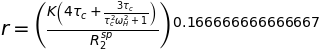

In [52]:
r, K, tc, wh = symbols('r K τ_c ω_H')
Eq(r,((K/R2sp)*(4*tc + (3*tc/(1+wh**2*tc**2))))**(1/6))

#solve(Eq(r,((K/R2sp)*(4*tc + (3*tc/(1+wh**2*tc**2))))**(1/6)),R2sp)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


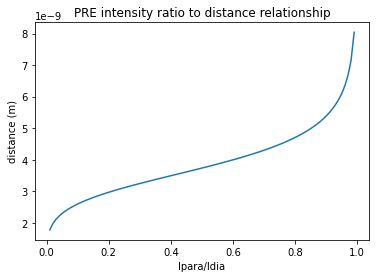

In [114]:
# combining the two equations to get r from Ipara/Idia
from scipy.special import lambertw
from numpy import linspace

# some constants
k = 1.23E-32  # cm^6 s^-2  # NB cm not m or A
r2 = 0.15     # 1/Hz = s   # calculated from amide linewidth = pi/R2
T = 9.0E-3    # s          # total length of INEPT delays in HSQC
Tc = 8.0e-9   # s          # estimated from structure or from 15N relaxation
Wh = 599.98E6 # Hz = s^-1  # 1H frequency of spectrometer used

def realLambertW(z):
  #takes a float, converts to complex, applies lambertw and returns real part
  compZ = complex(z,0)
  lwz = lambertw(compZ)
  #should check there's no complex part
  return lwz.real

def rFromIratio(Ir, r2, T, Tc, Wh, k=1.23E-32):
  #takes the intensity ratio and returns the coresponding distance
  Wbit = realLambertW((r2*T*exp(r2*T))/Ir)
  r = ((k/(-1*r2 + Wbit/T))*(4*Tc + (3*Tc/(1+Wh**2*Tc**2))))**(1/6)
  # convert to metres from centimetres
  r = r/100
  return r

# construct a calibration curve using the functions defined above
Iratio = linspace(0.01,1.0,101)
distances = []
for Ir in Iratio:
  r = rFromIratio(Ir, r2, T, Tc, Wh)
  distances.append(r)

# for drawing the graph
%matplotlib inline
import matplotlib.pyplot as plt

plt.title("PRE intensity ratio to distance relationship")
plt.xlabel('Ipara/Idia')
plt.ylabel('distance (m)')
plt.plot(Iratio,distances)
#plt.legend()

## Analysis of experimental data
Compare distances calculated from Ipara/Idia intensity ratios with those measured from the structure(s).

In [ ]:
#Read Ipara/Idia ratios by residue number as a pandas dataframe

#(Read diamagnetic 1H linewidths by residue number as pandas dataframe.
# Calculate averate linewidth for average R2 estimate or store per residue
# R2s to the Ipara/Idia dataframe for the distance extraction)

#Add column to store distances and calculate using rFromIratio() applying
# threshold and ceiling values

#Read distances of each amide H from the spin label attachment site as
# calculated from the structure(s) as a pandas dataframe

#Plot the PRE distances vs the structure distances and calculate correlation
# and stats by linear regression